In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

cwd=os.getcwd()
main_directory = os.path.abspath(os.path.join(cwd, '../../..')) # main directory
print(main_directory)
sys.path.append(main_directory) # add parent directory to the system path

/Users/gbemidebe/Documents/GitHub/monsur


In [22]:
import pandas as pd
import numpy as np
import random
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

from src.plot import plot_kde, plot_scatter
from src.utils import mse, mae, r2

In [23]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 13
plt.rcParams['figure.dpi'] = 200

In [24]:
# set random seed
rand_seed = 42
np.random.seed(rand_seed)
random.seed(rand_seed)

In [25]:
os.getcwd()

'/Users/gbemidebe/Documents/GitHub/monsur/sklearn/feh/RF'

In [26]:
data = pd.read_csv(f'{main_directory}/data/cleaned_data.csv')
data.drop(columns=['S/N'], inplace=True)
data.head()

,cDen,Pot,Sn %,pH,weight,Cu %,C2H4,CO,H2,EtoH,FORM
0,150,3.5,1.00,14.05,118.7100,0.00,0.00,0.23,0.12,0.00,0.61
1,150,3.3,0.80,14.05,107.6772,0.20,0.00,0.23,0.07,0.00,0.66
2,150,3.2,0.50,14.05,91.1280,0.50,0.00,0.34,0.05,0.03,0.52
3,150,3.1,0.10,14.05,69.0624,0.90,0.01,0.42,0.05,0.02,0.42
4,150,3.0,0.05,14.05,66.3042,0.95,0.04,0.48,0.05,0.10,0.19


In [27]:
data.columns

Index(['cDen', 'Pot', 'Sn %', 'pH', 'weight', 'Cu %', 'C2H4', 'CO', 'H2',
       'EtoH', 'FORM'],
      dtype='object')

In [28]:
# normalize the data to range [value/max, value/max]
feature_column = ['cDen', 'Pot', 'Sn %', 'pH', 'weight', 'Cu %']
target_column = ['FORM', 'EtoH', 'H2']
data[feature_column] = data[feature_column] / data[feature_column].max()
data.head()

,cDen,Pot,Sn %,pH,weight,Cu %,C2H4,CO,H2,EtoH,FORM
0,0.333333,0.744681,1.00,1.0,1.000000,0.00,0.00,0.23,0.12,0.00,0.61
1,0.333333,0.702128,0.80,1.0,0.907061,0.20,0.00,0.23,0.07,0.00,0.66
2,0.333333,0.680851,0.50,1.0,0.767652,0.50,0.00,0.34,0.05,0.03,0.52
3,0.333333,0.659574,0.10,1.0,0.581774,0.90,0.01,0.42,0.05,0.02,0.42
4,0.333333,0.638298,0.05,1.0,0.558539,0.95,0.04,0.48,0.05,0.10,0.19


In [29]:
num_points = data.shape[0]
X = data[feature_column].values
y = data[target_column].values
print(X.shape, y.shape)

(35, 6) (35, 3)


In [30]:
# split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

In [31]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_seed)

def optuna_objective(trial):

    

    n_estimators=trial.suggest_int(name='n_estimators',low=10, high=50, step=1)
    max_depth=trial.suggest_int(name='max_depth',low=3, high=10, step=1)
    max_features = trial.suggest_int(name='max_features', low=1, high=6, step=1)
    min_samples_leaf= trial.suggest_int(name='min_samples_leaf', low=1, high=10, step=1)

    model=RandomForestRegressor(n_estimators=n_estimators,
                              max_depth=max_depth,
                              max_features=max_features,
                              min_samples_leaf=min_samples_leaf,
                              random_state=42)
    
    regr = MultiOutputRegressor(model).fit(X_train_, y_train_)

    return regr.score(X_val, y_val)

#optimization pipeline
def optimizer_optuna(n_trials,algo):


    algo=optuna.samplers.TPESampler(n_startup_trials=20, n_ei_candidates=24)
    study=optuna.create_study(sampler=algo, direction='maximize')

    study.optimize(optuna_objective, n_trials=n_trials, show_progress_bar=False)

    print('\n', '\n', 'best params:', study.best_trial.params,
          '\n', '\n', 'best score:', study.best_trial.values,
          '\n')

    return study.best_trial.params,study.best_trial.values

#optimization approach
best_params,best_score=optimizer_optuna( 100 ,'TPE')


[I 2024-07-23 09:36:51,841] A new study created in memory with name: no-name-70a8b61d-60ee-4e74-b7b9-5ab8a97f6f37
[I 2024-07-23 09:36:51,901] Trial 0 finished with value: 0.3841630374143012 and parameters: {'n_estimators': 48, 'max_depth': 9, 'max_features': 4, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.3841630374143012.
[I 2024-07-23 09:36:51,959] Trial 1 finished with value: -0.18824366272332052 and parameters: {'n_estimators': 46, 'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.3841630374143012.
[I 2024-07-23 09:36:52,006] Trial 2 finished with value: 0.1380062173189169 and parameters: {'n_estimators': 39, 'max_depth': 6, 'max_features': 5, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.3841630374143012.
[I 2024-07-23 09:36:52,027] Trial 3 finished with value: -0.1758197907765521 and parameters: {'n_estimators': 17, 'max_depth': 7, 'max_features': 1, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.3841630374143012.
[


 
 best params: {'n_estimators': 29, 'max_depth': 6, 'max_features': 5, 'min_samples_leaf': 1} 
 
 best score: [0.8401415712743386] 



In [32]:
best_params

{'n_estimators': 29, 'max_depth': 6, 'max_features': 5, 'min_samples_leaf': 1}

In [33]:
miso=RandomForestRegressor(n_estimators=best_params['n_estimators'],
                            max_depth=best_params['max_depth'],
                            max_features=best_params['max_features'],
                            min_samples_leaf=best_params['min_samples_leaf'],
                            random_state=42)

mimo = MultiOutputRegressor(miso).fit(X_train, y_train)

In [34]:
mimo.predict

<bound method _MultiOutputEstimator.predict of MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=6,
                                                     max_features=5,
                                                     n_estimators=29,
                                                     random_state=42))>

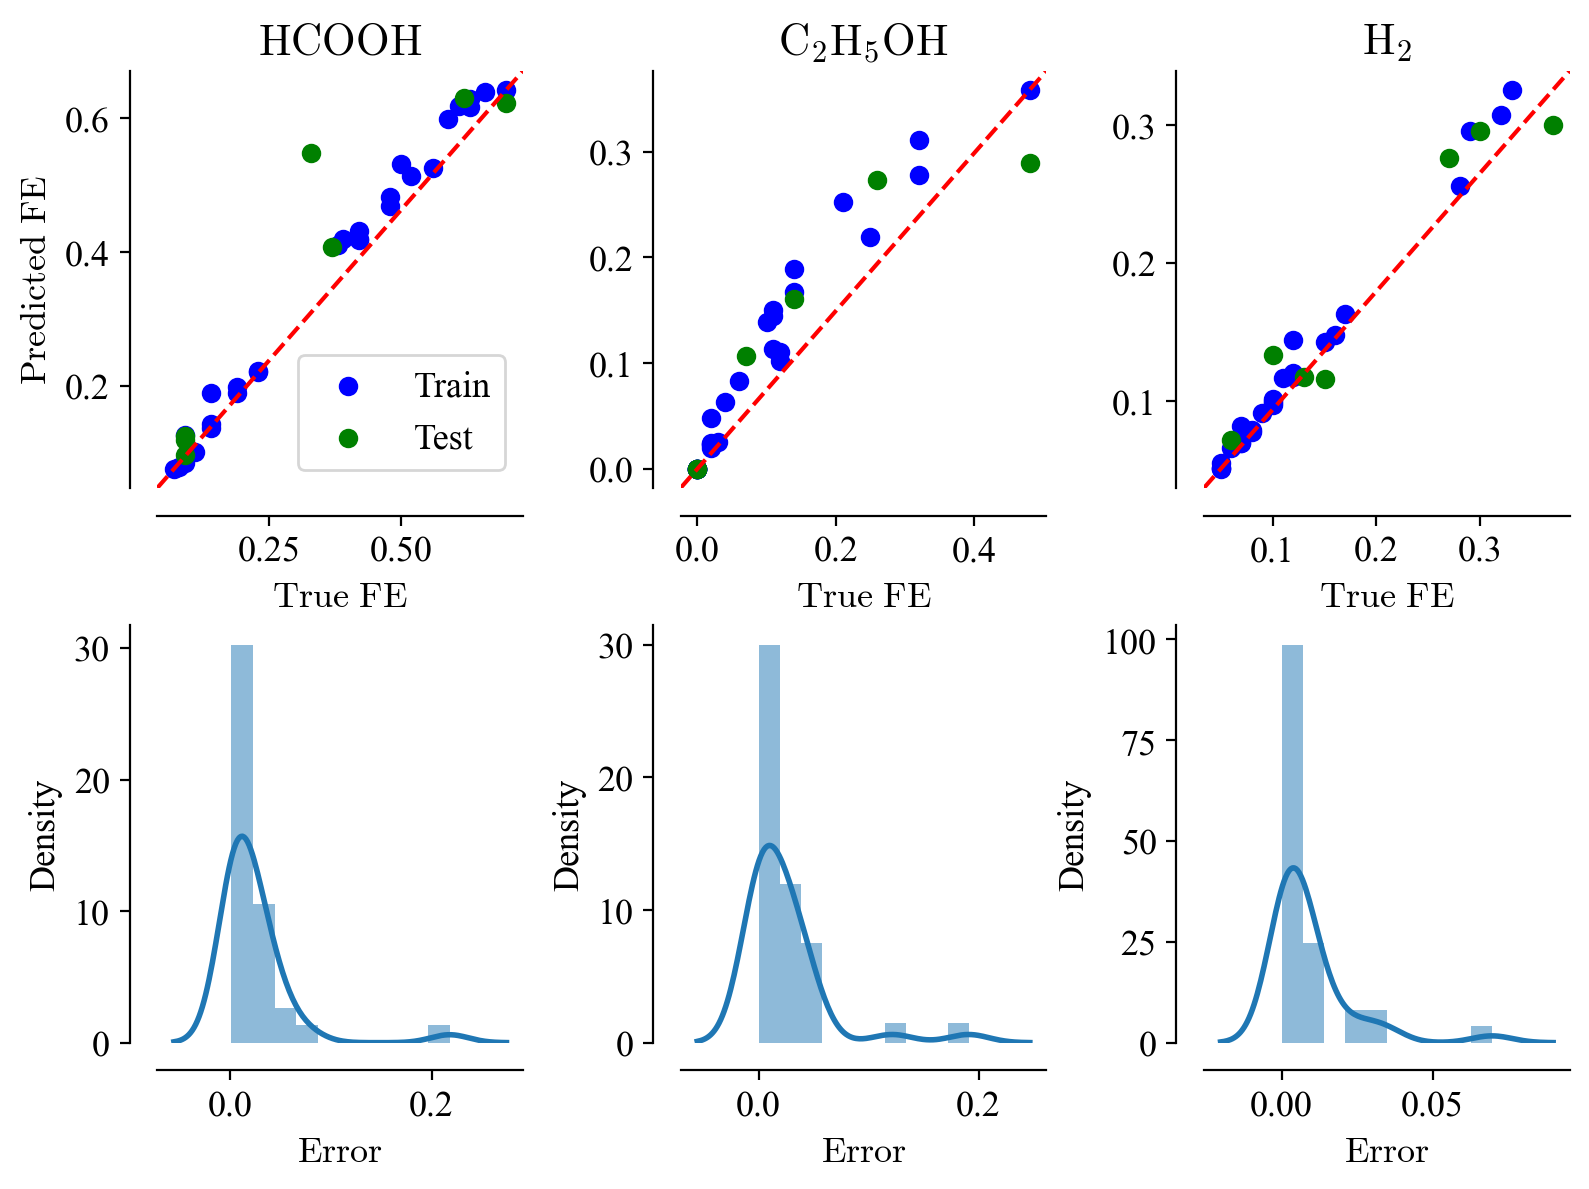

In [36]:
fig, ax = plt.subplots(2, 3, figsize=(8, 6))
plot_target_column = [r'$\rm HCOOH$', r'$\rm C_2H_5OH$', r'$\rm H_2$']
output_test = mimo.predict(X_test) # predict the test data
output = mimo.predict(X_train) # predict the training data

df = {
        'y_train': y_train, 'y_test': y_test, 
        'output_train': output, 'output_test': output_test
        }
# Plot scatter plots
for col in range(3):
    plot_scatter(ax=ax, data=df, row=0, col=col, column_names=plot_target_column, torch=False)

# Plot KDE plots
for col in range(3):
    plot_kde(ax=ax, data=df, row=1, col=col, torch=False)

plt.tight_layout()
sns.despine(fig=fig, offset=10)
plt.show()


In [37]:
metric = {
    "Metric": ["MSE", "R2", "MAE"],
    "HCOOH Train": [mse(y_train[:, 0], output[:, 0]), r2(y_train[:, 0], output[:, 0]), mae(y_train[:, 0], output[:, 0])],
    "HCOOH Test": [mse(y_test[:, 0], output_test[:, 0]), r2(y_test[:, 0], output_test[:, 0]), mae(y_test[:, 0], output_test[:, 0])],
    "C2H5OH Train": [mse(y_train[:, 1], output[:, 1]), r2(y_train[:, 1], output[:, 1]), mae(y_train[:, 1], output[:, 1])],
    "C2H5OH Test": [mse(y_test[:, 1], output_test[:, 1]), r2(y_test[:, 1], output_test[:, 1]), mae(y_test[:, 1], output_test[:, 1])],
    "H2 Train": [mse(y_train[:, 2], output[:, 2]), r2(y_train[:, 2], output[:, 2]), mae(y_train[:, 2], output[:, 2])],
    "H2 Test": [mse(y_test[:, 2], output_test[:, 2]), r2(y_test[:, 2], output_test[:, 2]), mae(y_test[:, 2], output_test[:, 2])]
}

metric_df = pd.DataFrame(metric)
metric_df

,Metric,HCOOH Train,HCOOH Test,C2H5OH Train,C2H5OH Test,H2 Train,H2 Test
0,MSE,0.000,0.008,0.001,0.005,0.000,0.001
1,R2,0.990,0.856,0.926,0.802,0.990,0.907
2,MAE,0.015,0.059,0.020,0.037,0.005,0.025


In [38]:
with open(f'./random_forest.pkl', 'wb') as f:
    pickle.dump(mimo, f)